In [1]:
# import the necessary libraries
import torch
import torchvision
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import os
import random
import matplotlib.image as mpimg

In [2]:
# store the path of training images in a variable
train_dir = "../input/100-bird-species/train"
# store the path of test images in a variable
val_dir = "../input/100-bird-species/valid"

In [3]:
# compose several transforms of the images together
transform_ds = T.Compose([T.Resize((128, 128)),
                          T.RandomHorizontalFlip(),
                          T.ToTensor()
                         ])

# store the dataset as a subclass of torchvision.datasets
train_ds = torchvision.datasets.ImageFolder(root=train_dir, transform=transform_ds)
val_ds = torchvision.datasets.ImageFolder(root=val_dir, transform=transform_ds)

In [4]:
# check the number of classes of the training set
print('Number of classes of the training set: {} '.format(len(train_ds.classes)))
print('*****************************************')
# check the number of classes of the validation set
print('Number of classes of the validation set: {} '.format(len(val_ds.classes)))

Number of classes of the training set: 260 
*****************************************
Number of classes of the validation set: 260 


### Data Visualization of some random Bird Species

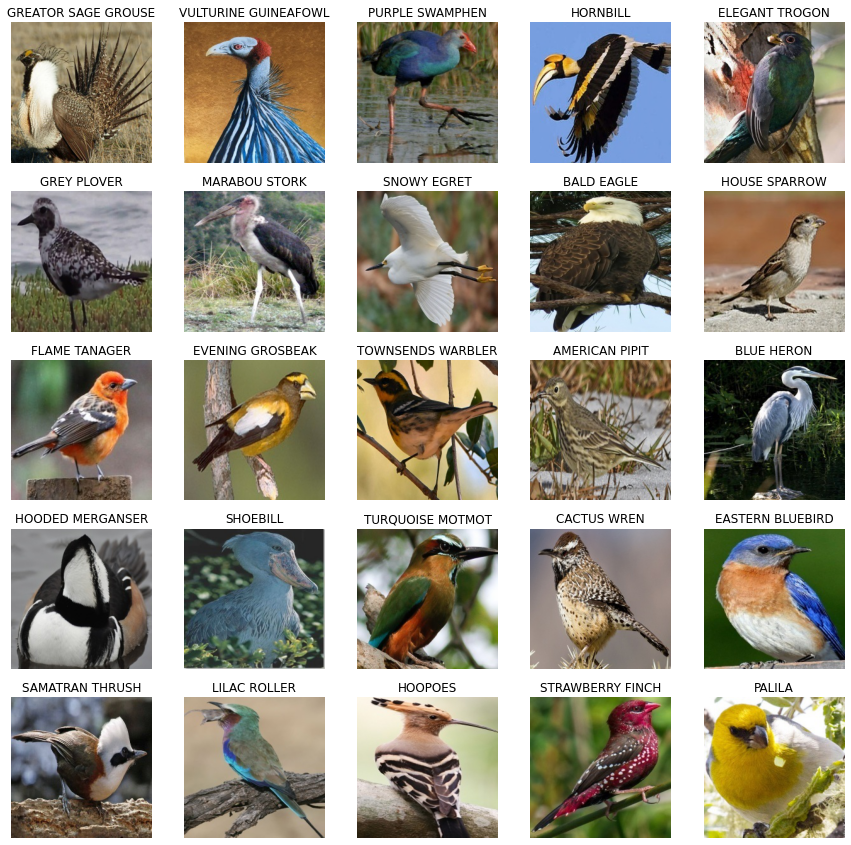

In [5]:
consolidated_path = '../input/100-bird-species/consolidated/'

def display_random_birds(ncols=5, ds_path=consolidated_path):
    fig, ax = plt.subplots(ncols=ncols, nrows=ncols, figsize=(15, 15))
    
    for i in range(ncols):
        for j in range(ncols):
            bird_species = random.choice(os.listdir(ds_path))
            random_bird_path = random.choice(os.listdir(ds_path + bird_species))
            random_bird = mpimg.imread(ds_path + bird_species + '/' + random_bird_path)
            ax[i, j].imshow(random_bird)
            ax[i, j].set_title(bird_species)
            ax[i, j].axis('off')
            
display_random_birds()

In [6]:
# create a batch size for the images
batch_size = 128

# Load the dataset from directory in torchvision.datasets
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

### Moving data to GPU device

In [7]:
# function to get the GPU device
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# function to transfer the data to the GPU device
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Class instance to load the data from the GPU device
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)
            
    def __len__(self):
        return len(self.dl)

In [8]:
# display the GPU device
device = get_device()
device

device(type='cuda')

In [9]:
# transfer the training set and validation set to the GPU device data loader
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

### Modelling

In [10]:
# define accuracy function for the model
def accuracy(out, labels):
    _, preds = torch.max(out, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [11]:
# create a class instance of the neural network module and the functions involved  
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss": loss.detach(), "val_acc": acc}
    
    def validation_epoch_end(self, outputs):
        batch_loss = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}
    
    def epoch_end(self, epoch, epochs, result):
        print("Epoch: [{}/{}], last_lr: {:.6f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, epochs, result["lrs"][-1], result["train_loss"], result["val_loss"], result["val_acc"]))

In [12]:
# create a class instance of the ResNet18 pretrained model for transfer learning
class model(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.network = models.resnet18(pretrained=True)
        number_of_features = self.network.fc.in_features
        self.network.fc = nn.Linear(number_of_features, num_classes)
        
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        for param in self.network.parameters():
            param.requires_grad= False
        for param in self.network.fc.parameters():
            param.requires_grad= True
        
    def unfreeze(self):
        for param in self.network.parameters():
            param.requires_grad= True

In [13]:
# ResNet18 model architecture
model = to_device(model(num_classes=260), device)
model

model(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

### Training

In [14]:
# disable gradient calculation
@torch.no_grad()

# function for model evaluation
def evaluate(model, val_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

# function to get learning rate optimizer
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

# function to fit the training set and validation set into the model
def fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, weight_decay=0, grad_clip=None,
                 opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    
    history = []
    
    opt = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr, epochs=epochs,
                                               steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        train_loss = []
        lrs = []
        for batch in tqdm(train_dl):
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            opt.step()
            opt.zero_grad()
            
            lrs.append(get_lr(opt))
            sched.step()
            
        result = evaluate(model, val_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, epochs, result)
        history.append(result)
    return history

In [15]:
result = [evaluate(model, val_dl)]
result

[{'val_loss': 6.206394672393799, 'val_acc': 0.0049715908244252205}]

In [16]:
epochs = 10
max_lr = 10e-5
grad_clip = 0.1
weight_decay = 10e-4
opt_func = torch.optim.Adam

history = fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                        weight_decay=weight_decay, 
                        grad_clip=grad_clip,
                        opt_func=opt_func)

  0%|          | 0/287 [00:00<?, ?it/s]

Epoch: [1/10], last_lr: 0.000028, train_loss: 5.4366, val_loss: 4.4423, val_acc: 0.1645


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch: [2/10], last_lr: 0.000076, train_loss: 3.1534, val_loss: 1.4864, val_acc: 0.7899


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch: [3/10], last_lr: 0.000100, train_loss: 1.2044, val_loss: 0.5269, val_acc: 0.9116


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch: [4/10], last_lr: 0.000095, train_loss: 0.5567, val_loss: 0.3244, val_acc: 0.9457


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch: [5/10], last_lr: 0.000081, train_loss: 0.3157, val_loss: 0.2383, val_acc: 0.9536


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch: [6/10], last_lr: 0.000061, train_loss: 0.1955, val_loss: 0.2109, val_acc: 0.9614


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch: [7/10], last_lr: 0.000039, train_loss: 0.1340, val_loss: 0.1790, val_acc: 0.9670


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch: [8/10], last_lr: 0.000019, train_loss: 0.1023, val_loss: 0.1742, val_acc: 0.9649


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch: [9/10], last_lr: 0.000005, train_loss: 0.0844, val_loss: 0.1803, val_acc: 0.9692


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch: [10/10], last_lr: 0.000000, train_loss: 0.0784, val_loss: 0.1773, val_acc: 0.9670


### Predictions

In [17]:
# store test images path into a directory
test_dir = "../input/100-bird-species/test"

In [18]:
# compose several transforms of the test images together
transform_test = T.Compose([
    T.Resize((128,128)),
    T.ToTensor()
])

test_ds = torchvision.datasets.ImageFolder(root=test_dir, transform=transform_test)

In [19]:
# define a funtion to return the model predictions
def prediction(model, images):
    xb = to_device(images.unsqueeze(0), device)
    out = model(xb)
    _, preds = torch.max(out, dim=1)
    predictions = test_ds.classes[preds[0].item()]
    return predictions

Label:  ALBATROSS
Prediction:  ALBATROSS


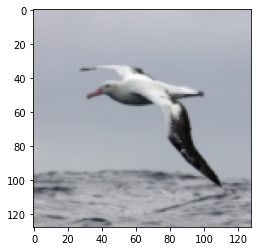

In [20]:
# predict bird specie
images, labels = test_ds[10]
print("Label: ", test_ds.classes[labels])
print("Prediction: ", prediction(model, images))
plt.imshow(images.permute(1,2,0))

### Metrics Performance

Text(0, 0.5, 'Accuracy')

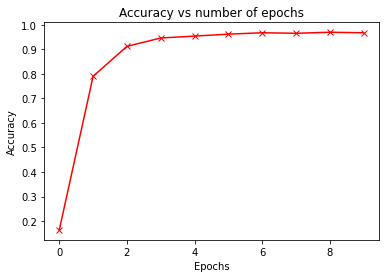

In [21]:
# validation accuracy
accuracy = [x["val_acc"] for x in history]
plt.plot(accuracy, "-rx")
plt.title("Accuracy vs number of epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Losses')

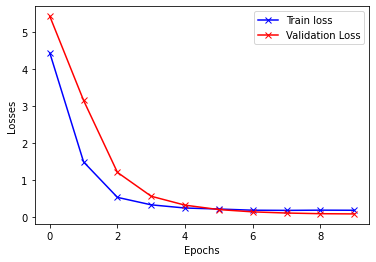

In [22]:
# train loss and validation loss
val_loss = [x["val_loss"] for x in history]
train_loss = [x.get("train_loss") for x in history]
plt.plot(val_loss, "-bx")
plt.plot(train_loss, "-rx")
plt.legend(["Train loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")